# Greenness (gcc) Predictions:
##### Target Variables (#35): gcc of next 35 days
##### Features Used (#25): Last 7 days gcc value i.e. gcc90 value from (t-1)th to (t-5)th day + gcc90 value from (t-5)th to (t+14)th day of last year
##### Model used: Random Forest Regressor
##### Cross-validation strategy used: Time Series Cross Validator (In each split, test indices must be higher) 
##### Train Data: Till 2019
##### Test Data: 2020
##### Missing values in the train data has been has been filled with interpolate(method = time) function.

*** Model trained separately for each of the sites and hyperparemeters of Random Forest Regressor are also different for each of the sites.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
pdf = matplotlib.backends.backend_pdf.PdfPages("GCC_Predictions_Result_interpolating_missing_data.pdf")

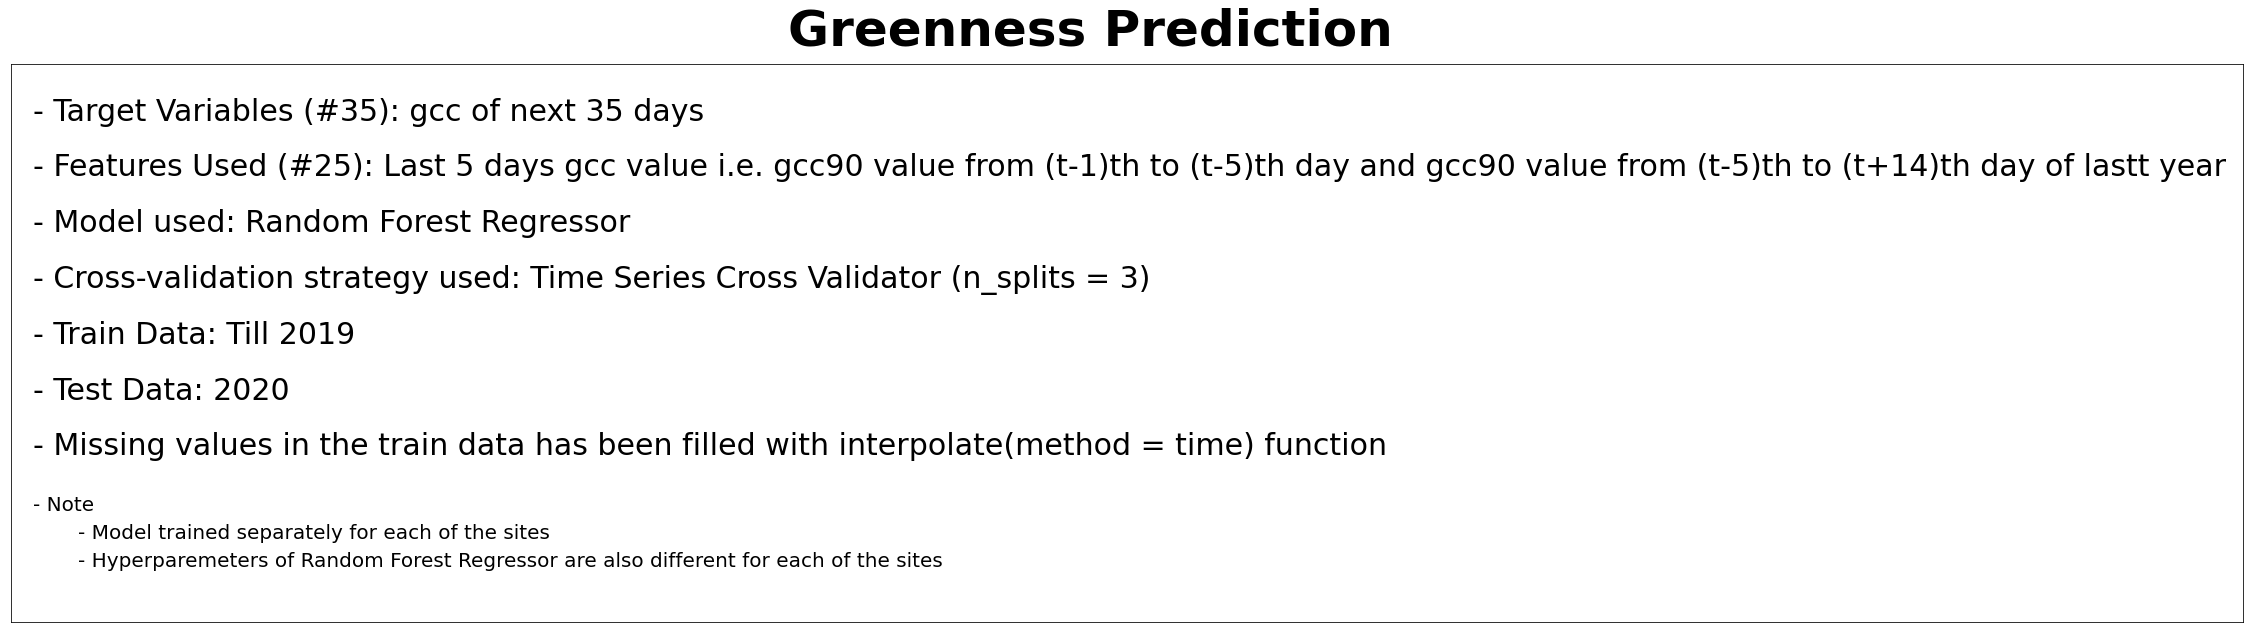

In [2]:
fig = plt.figure(figsize=(40,10))
fig.suptitle('Greenness Prediction', fontsize = 50, fontweight='bold')
#ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(0.01, 0.9, '- Target Variables (#35): gcc of next 35 days', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.8, '- Features Used (#25): Last 5 days gcc value i.e. gcc90 value from (t-1)th to (t-5)th day and gcc90 value from (t-5)th to (t+14)th day of lastt year', 
         fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.7, '- Model used: Random Forest Regressor', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.6, '- Cross-validation strategy used: Time Series Cross Validator (n_splits = 3)', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.5, '- Train Data: Till 2019', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.4, '- Test Data: 2020', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.3, '- Missing values in the train data has been filled with interpolate(method = time) function', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.2, '- Note', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.15, '- Model trained separately for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.1, '- Hyperparemeters of Random Forest Regressor are also different for each of the sites', fontsize = 20, horizontalalignment = 'left')
pdf.savefig()

In [56]:
# Importing the dataset gcc_weather.csv
url = "https://raw.githubusercontent.com/genophenoenvo/neon-datasets/main/pheno_images/gcc_weather.csv"
dataset = pd.read_csv(url)
print("Shape of imported dataset:" + str(dataset.shape))
print("\nColumns of imported dataset:")
print(dataset.columns)

Shape of imported dataset:(12440, 11)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'gcc_sd', 'daylength', 'precipitation',
       'radiation', 'snow_water_equiv', 'max_temp', 'min_temp',
       'vapor_pressure'],
      dtype='object')


In [4]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
dataset = dataset.set_index("time")

In [5]:
# Selecting the required columns: siteID and gcc90 and date related columns
gcc_data = dataset[["siteID", "gcc_90", "year", "month", "day", "year_month"]]
print("Shape:" + str(gcc_data.shape))
site_list = gcc_data["siteID"].unique()
print("Sites:")
print(site_list)

Shape:(12152, 6)
Sites:
['HARV' 'BART' 'SCBI' 'STEI' 'UKFS' 'GRSM' 'DELA' 'CLBJ']


In [6]:
#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
site_data = []
for i in range(0,8):
    site_data.append(gcc_data_by_site.get_group(site_list[i]))

In [7]:
site_data[0]

,siteID,gcc_90,year,month,day,year_month
time,,,,,,
2016-12-13,HARV,0.32901,2016,12,13,2016-12
2016-12-14,HARV,0.32811,2016,12,14,2016-12
2016-12-15,HARV,0.32955,2016,12,15,2016-12
2016-12-16,HARV,0.32874,2016,12,16,2016-12
2016-12-17,HARV,0.33152,2016,12,17,2016-12
...,...,...,...,...,...,...
2021-02-04,HARV,NaN,2021,2,4,2021-2
2021-02-05,HARV,NaN,2021,2,5,2021-2
2021-02-06,HARV,NaN,2021,2,6,2021-2


In [8]:
#Creating features by using shift() function
input_features = []
target_variables = ['gcc_90']
for k in range(0,8):
    for i in range(1,35):
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        if(k == 0):
            target_variables.append(col_name_ahead)
        site_data[k].loc[:,col_name_ahead] = site_data[k].loc[:,"gcc_90"].shift(-i)
    for i in range(1,6):
        col_name = "gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name)
        site_data[k].loc[:,col_name] = site_data[k].loc[:,"gcc_90"].shift(i)
    for i in range(1,6):
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        site_data[k].loc[:,col_name_last_year] = site_data[k].loc[:,"gcc_90"].shift(i+365)
    for i in range(0,15):
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        site_data[k].loc[:,col_name_last_year_ahead] = site_data[k].loc[:,"gcc_90"].shift(365-i)

C:\Users\palde\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\palde\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [9]:
print("Columns in each of the site's dataframe:")
site_data[0].columns

Columns in each of the site's dataframe:


Index(['siteID', 'gcc_90', 'year', 'month', 'day', 'year_month',
       'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)',
       'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)',
       'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)',
       'gcc_90_(t+13)', 'gcc_90_(t+14)', 'gcc_90_(t+15)', 'gcc_90_(t+16)',
       'gcc_90_(t+17)', 'gcc_90_(t+18)', 'gcc_90_(t+19)', 'gcc_90_(t+20)',
       'gcc_90_(t+21)', 'gcc_90_(t+22)', 'gcc_90_(t+23)', 'gcc_90_(t+24)',
       'gcc_90_(t+25)', 'gcc_90_(t+26)', 'gcc_90_(t+27)', 'gcc_90_(t+28)',
       'gcc_90_(t+29)', 'gcc_90_(t+30)', 'gcc_90_(t+31)', 'gcc_90_(t+32)',
       'gcc_90_(t+33)', 'gcc_90_(t+34)', 'gcc_90_(t-1)', 'gcc_90_(t-2)',
       'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)',
       'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)',
       'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)',
       'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)',
       'last_year_gcc_90_(t+1)', 'last_

In [10]:
print("Input Features:\n" + str(input_features))
print("\nTarget Variables:\n" + str(target_variables))

Input Features:
['gcc_90_(t-1)', 'gcc_90_(t-2)', 'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)', 'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)', 'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)', 'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)', 'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)', 'last_year_gcc_90_(t+8)', 'last_year_gcc_90_(t+9)', 'last_year_gcc_90_(t+10)', 'last_year_gcc_90_(t+11)', 'last_year_gcc_90_(t+12)', 'last_year_gcc_90_(t+13)', 'last_year_gcc_90_(t+14)']

Target Variables:
['gcc_90', 'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)', 'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)', 'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)', 'gcc_90_(t+13)', 'gcc_90_(t+14)', 'gcc_90_(t+15)', 'gcc_90_(t+16)', 'gcc_90_(t+17)', 'gcc_90_(t+18)', 'gcc_90_(t+19)', 'gcc_90_(t+20)', 'gcc_90_(t+21)', 

In [11]:
for k in range(0,8):
    df =  site_data[k].copy()
    
    df.drop(pd.Timestamp("2020-02-29"), inplace = True, errors = 'ignore')
    
    baseline_df = df[["siteID"]]
    avg = pd.DataFrame()
    
    avg["ly_1"] = df.loc[:, "gcc_90"].shift(365)
    avg["ly_2"] = df.loc[:, "gcc_90"].shift(365*2)
    avg["ly_3"] = df.loc[:, "gcc_90"].shift(365*3)
    avg["mean"] = avg.mean(axis = 1, skipna = True)
    baseline_df["baseline_gcc_90"] = avg["mean"]
    
    for i in range(1,35):
        baseline_col_name_ahead = "baseline_gcc_90_(t+"+str(i)+")"
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        avg = pd.DataFrame()
        avg["ly_1"] = df.loc[:, col_name_ahead].shift(365)
        avg["ly_2"] = df.loc[:, col_name_ahead].shift(365*2)
        avg["ly_3"] = df.loc[:, col_name_ahead].shift(365*3)
        avg["mean"] = avg.mean(axis = 1, skipna = True)
        baseline_df[baseline_col_name_ahead] = avg["mean"]
    
    baseline_df.drop("siteID", inplace = True, axis =1)
    site_data[k] = site_data[k].join(baseline_df, how ='outer')

<ipython-input-11-22a5ad531df3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["baseline_gcc_90"] = avg["mean"]
<ipython-input-11-22a5ad531df3>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df[baseline_col_name_ahead] = avg["mean"]
C:\Users\palde\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [12]:
list(site_data[0].columns)

['siteID',
 'gcc_90',
 'year',
 'month',
 'day',
 'year_month',
 'gcc_90_(t+1)',
 'gcc_90_(t+2)',
 'gcc_90_(t+3)',
 'gcc_90_(t+4)',
 'gcc_90_(t+5)',
 'gcc_90_(t+6)',
 'gcc_90_(t+7)',
 'gcc_90_(t+8)',
 'gcc_90_(t+9)',
 'gcc_90_(t+10)',
 'gcc_90_(t+11)',
 'gcc_90_(t+12)',
 'gcc_90_(t+13)',
 'gcc_90_(t+14)',
 'gcc_90_(t+15)',
 'gcc_90_(t+16)',
 'gcc_90_(t+17)',
 'gcc_90_(t+18)',
 'gcc_90_(t+19)',
 'gcc_90_(t+20)',
 'gcc_90_(t+21)',
 'gcc_90_(t+22)',
 'gcc_90_(t+23)',
 'gcc_90_(t+24)',
 'gcc_90_(t+25)',
 'gcc_90_(t+26)',
 'gcc_90_(t+27)',
 'gcc_90_(t+28)',
 'gcc_90_(t+29)',
 'gcc_90_(t+30)',
 'gcc_90_(t+31)',
 'gcc_90_(t+32)',
 'gcc_90_(t+33)',
 'gcc_90_(t+34)',
 'gcc_90_(t-1)',
 'gcc_90_(t-2)',
 'gcc_90_(t-3)',
 'gcc_90_(t-4)',
 'gcc_90_(t-5)',
 'last_year_gcc_90_(t-1)',
 'last_year_gcc_90_(t-2)',
 'last_year_gcc_90_(t-3)',
 'last_year_gcc_90_(t-4)',
 'last_year_gcc_90_(t-5)',
 'last_year_gcc_90_(t+0)',
 'last_year_gcc_90_(t+1)',
 'last_year_gcc_90_(t+2)',
 'last_year_gcc_90_(t+3)',
 'las

In [13]:
site_data[0].shape[0]

1519

In [14]:
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,8):
    data_count[site_list[k]] =  site_data[k].groupby("year").count().iloc[:, 1]
data_count

,HARV,BART,SCBI,STEI,UKFS,GRSM,DELA,CLBJ
2016,19,18,19,0,0,0,16,0
2017,347,330,353,57,0,306,353,25
2018,365,362,344,356,48,365,365,355
2019,358,343,363,363,352,350,361,365
2020,315,362,362,365,334,365,344,358
2021,27,27,28,33,33,39,39,39


In [15]:
best_models = []
overall_rmse_score = []
overall_r2_score = []
target_variable_wise_score = []
interpolated_train_data = []
true_results = []
predicted_results = []
train_test_size = {"Site_Name": [], "Train_Size": [],"Test_Size" : []}

for k in range(0,8):
    print("\n" + str(site_list[k]) + ":\n")
    
    train_data = site_data[k][site_data[k].columns.intersection(input_features+target_variables)].loc[:'2019', :]
    train_data.interpolate(method='time', inplace=True, #limit = 15, limit_area='inside', limit_direction='both'
                          )
    interpolated_train_data.append(train_data)
    train_data.dropna(inplace = True)
    
    test_data = site_data[k][site_data[k].columns.intersection(input_features+target_variables)].loc['2020', :]
    test_data.dropna(inplace = True)
    
    X_train = train_data[train_data.columns.intersection(input_features)]
    Y_train = train_data[train_data.columns.intersection(target_variables)]
    X_test = test_data[test_data.columns.intersection(input_features)]
    Y_test = test_data[test_data.columns.intersection(target_variables)]
    
    train_test_size["Site_Name"].append(site_list[k])
    train_test_size["Train_Size"].append(X_train.shape[0])
    train_test_size["Test_Size"].append(X_test.shape[0])

    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score.append(rmse)
    overall_r2_score.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


HARV:

Shape of X_train:(744, 25)
Shape of Y_train:(744, 35)
Shape of X_test:(200, 25)
Shape of Y_test:(200, 35)
RMSE of Training Data: -0.022470216948100915
Model:RandomForestRegressor(max_depth=7, max_features='sqrt', random_state=0)
explained_variance: 0.9567489248575277
RMSE: 0.009136522567129593
R2: 0.9541133123440655
------------------------------------------------------------------------

BART:

Shape of X_train:(743, 25)
Shape of Y_train:(743, 35)
Shape of X_test:(201, 25)
Shape of Y_test:(201, 35)
RMSE of Training Data: -0.01716531905645909
Model:RandomForestRegressor(max_depth=14, max_features='log2', random_state=0)
explained_variance: 0.9373862139465895
RMSE: 0.011929188533886536
R2: 0.9310029434425788
------------------------------------------------------------------------

SCBI:

Shape of X_train:(744, 25)
Shape of Y_train:(744, 35)
Shape of X_test:(238, 25)
Shape of Y_test:(238, 35)
RMSE of Training Data: -0.02068083697372768
Model:RandomForestRegressor(max_depth=14, ma

In [49]:
pdf.close()

In [51]:
UKFS_train_data = site_data[4][site_data[4].columns.intersection(input_features+target_variables)]
UKFS_train_data.interpolate(method='time', inplace=True, #limit = 15, limit_area='inside', limit_direction='both'
                          )
interpolated_train_data[4] = UKFS_train_data
UKFS_train_data.dropna(inplace = True)
    
UKFS_X_train = UKFS_train_data[UKFS_train_data.columns.intersection(input_features)]
UKFS_Y_train = UKFS_train_data[UKFS_train_data.columns.intersection(target_variables)]

    
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))
    
model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models[4] = best_model
print("RMSE of UKFS Training Data: " + str(best_score))
print("Model:" + str(best_model))

<ipython-input-51-8186161936f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UKFS_train_data.interpolate(method='time', inplace=True, #limit = 15, limit_area='inside', limit_direction='both'
<ipython-input-51-8186161936f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UKFS_train_data.dropna(inplace = True)


Shape of X_train:(448, 25)
Shape of Y_train:(448, 35)
RMSE of UKFS Training Data: -0.034071014725169727
Model:RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=10,
                      random_state=0)
